<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4 Modeling

This notebook covers our modeling sections where we will implement several classification algorithims and sampling techniques to evaluate model performance. We will analyze the results and discuss key classification metrics for fraud detection. Due to the size of our data and project time constraints, we will evaluate model performance on a subset of 100k data points. All of the analysis in this notebook is done leverging this subset. Based on our findings, we will select the best model to run on the entire, 2 million observation dataset in the final model notebook.

#### Model imports

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, \
accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay)

from sklearn.metrics import make_scorer, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

#### Read in preprocessed data

In [2]:
df = pd.read_csv('data/preprocessed_subsample_100k.csv')
df.head()

,lat,long,amt,is_fraud,merch_lat,merch_long,timedelta,time,weekday,avg_long_rolling_10,...,category_misc_net_fraction_rolling_100,category_misc_pos_fraction_rolling_100,category_personal_care_fraction_rolling_100,category_shopping_net_fraction_rolling_100,category_shopping_pos_fraction_rolling_100,category_travel_fraction_rolling_100,thirty_day_avg_amt,total_daily_amount,total_daily_transactions,probability_density
0,0.621990,-1.441024,18.24,0,0.621654,-1.428358,0,12960,1,-1.441024,...,0.0,0.0,0.0,0.0,0.0,0.0,18.24,18.24,1,2.098347e-110
1,0.770415,-1.801271,7.42,0,0.780922,-1.795226,0,23040,1,-1.801271,...,0.0,0.0,0.0,0.0,0.0,0.0,7.42,7.42,1,2.633248e-107
2,0.607542,-1.570962,82.07,0,0.602956,-1.553939,0,73440,5,-1.570962,...,0.0,0.0,0.0,0.0,0.0,0.0,82.07,82.07,1,2.161357e-98
3,0.800787,-1.664730,43.03,0,0.791665,-1.659873,0,10080,0,-1.664730,...,0.0,0.0,0.0,0.0,0.0,0.0,43.03,43.03,1,8.763737e-103
4,0.534614,-1.538661,80.40,0,0.519655,-1.521959,0,10080,0,-1.538661,...,0.0,0.0,0.0,0.0,0.0,0.0,80.40,80.40,1,4.077040e-105


In [3]:
df.shape

(100000, 91)

In [4]:
# drop the probability density feature for now
df.drop(['probability_density'], axis=1, inplace=True)

In [5]:
df.shape

(100000, 90)

#### Set up our x and y

In [6]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

In [7]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: is_fraud, Length: 100000, dtype: int64

In [8]:
y.value_counts()

0    99137
1      863
Name: is_fraud, dtype: int64

In [9]:
y.value_counts(normalize=True).mul(100).round(2)

0    99.14
1     0.86
Name: is_fraud, dtype: float64

### Train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1,
                                                    random_state = 42, 
                                                    stratify = y)

In [11]:
print(y_train.value_counts(normalize=True).mul(100).round(2))
print(y_train.value_counts())

0    99.14
1     0.86
Name: is_fraud, dtype: float64
0    89223
1      777
Name: is_fraud, dtype: int64


### Scale our data

In [12]:
# Scale our data...
ss = StandardScaler()

# Scaler fits or trains on the X_train only - does not see the
# X_test (or imagined new data). 
X_train_sc = ss.fit_transform(X_train)

# We take the scaling from X_train and apply that to the X_test 
X_test_sc = ss.transform(X_test)

### Logistic regression model without leverging class imbalance sampling techniques

In [13]:
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
lr.score(X_train_sc, y_train), lr.score(X_test_sc, y_test)

(0.9979, 0.9978)

In [14]:
# leverage function from GA lesson on smote
def metrics(y_test, y_predict):
    print(f"Accuracy score: {accuracy_score(y_test, y_predict)} \n")
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['not_fraud', 'Actually_fraud'], 
                            columns=['Predicted_not_Fraud', 'Predicted_fraud']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')

In [15]:
y_preds = lr.predict(X_test_sc)

In [16]:
pd.Series(y_preds).value_counts(), y_test.value_counts()

(0    9924
 1      76
 dtype: int64,
 0    9914
 1      86
 Name: is_fraud, dtype: int64)

In [17]:
metrics(y_test, y_preds)

Accuracy score: 0.9978 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                      9908                6
Actually_fraud                   16               70 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9914
           1       0.92      0.81      0.86        86

    accuracy                           1.00     10000
   macro avg       0.96      0.91      0.93     10000
weighted avg       1.00      1.00      1.00     10000

-----------------------------------------------------------------


We note our model performs well in terms of accuracy, however that is not a good indication of a useful model when dealing with highly imbalanced classes. We will use a Synthetic Minority Oversampling Technique aka SMOTE to address the issue with imbalanced classes. SMOTE is a data augmentation technique which selects instances of our minority class in the feature space at random. It selects a sample from the minority class and finds its k nearest neighbors, then it generates synthetic samples at a random point between the selected sample and its neighbors.  new The new synthetic samples are selected along the line between the selected sample and its nearest neighbors in the feature space.

### Logistic Regression gridsearch with SMOTE

In [18]:
# Now we can create synthetic data for our training set
sm = SMOTE(random_state=42, n_jobs=-1)

X_train_smote, y_train_smote = sm.fit_resample(X_train_sc, y_train)

In [19]:
X_train_smote.shape, y_train_smote.shape

((178446, 89), (178446,))

In [20]:
y_train_smote.value_counts()

0    89223
1    89223
Name: is_fraud, dtype: int64

In [21]:
pipe_lr = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(max_iter=10000))
    ])

pipe_params_lr = {
    'sampling__sampling_strategy': ['not minority'],
    'sampling__k_neighbors': [3],
    'logreg__C': [0.1]
}


# Best params from grid search below:
# pipe_params = {
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5, 7],
#     'logreg__C': [0.1, 0.5, 1]
# }

# {'logreg__C': 0.1,
#  'sampling__k_neighbors': 3,
#  'sampling__sampling_strategy': 'not minority'}

We note due to time constraints, we conducted our gridsearch for all algorithms in this notebook with a subset of 100,000 samples to determine the best tuned hyperparameters. We used the best settings from the 100k sample on our complete data set with two million samples. With more, we would run another experimental design on the full data set to determine the best tuned hyper-parameters. The full experimental design tested is commented out in the code and the best settings are what we left when running the code as is.

In [22]:
grid_lr = GridSearchCV(pipe_lr, pipe_params_lr, n_jobs=-1)

In [23]:
grid_lr.fit(X_train, y_train)
grid_lr.score(X_train, y_train), grid_lr.score(X_test, y_test)

(0.9978888888888889, 0.9979)

In [24]:
grid_lr.best_params_

{'logreg__C': 0.1,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'not minority'}

In [25]:
grid_preds_lr = grid_lr.predict(X_test)
metrics(y_test, grid_preds_lr)

Accuracy score: 0.9979 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                      9908                6
Actually_fraud                   15               71 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9914
           1       0.92      0.83      0.87        86

    accuracy                           1.00     10000
   macro avg       0.96      0.91      0.94     10000
weighted avg       1.00      1.00      1.00     10000

-----------------------------------------------------------------


Leverging sklearns built in smote class, we see improved metrics in terms of a reduction in False negatives. We will use smote with a few more classificaiton algorithims and develop a custom scoring function to emphasis recall since we are concerned mostly with false negatives. Recall is a very important metric in highly imbalanced class problems such as fraud detection and will likely be used as a key indicator of model perfomrance.  Lastly, we will compare classification metrics to determine our final model

# Random Forest grid search with SMOTE

In [29]:
pipe_rf = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('rfc', RandomForestClassifier())
    ])

pipe_params_rf = {
     'sampling__sampling_strategy': ['not minority'],
     'sampling__k_neighbors': [15],
     'rfc__max_depth': [100]
}


# results from grid search below:
# pipe_params_rf = {
#      'sampling__sampling_strategy': ['not minority'],
#      'sampling__k_neighbors': [15, 20, 25],
#      'rfc__max_depth': [60, 100, 150]
# }

# Best params:
# {'rfc__max_depth': 100,
#  'sampling__k_neighbors': 15,
#  'sampling__sampling_strategy': 'not minority'}

In [30]:
grid_rf = GridSearchCV(pipe_rf, pipe_params_rf, n_jobs=-1)
grid_rf.fit(X_train, y_train)
grid_rf.score(X_train, y_train), grid_rf.score(X_test, y_test)

(1.0, 0.9994)

In [31]:
grid_rf.best_params_

{'rfc__max_depth': 100,
 'sampling__k_neighbors': 15,
 'sampling__sampling_strategy': 'not minority'}

In [32]:
grid_preds_rf = grid_rf.predict(X_test)

In [33]:
metrics(y_test, grid_preds_rf)

Accuracy score: 0.9994 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                      9914                0
Actually_fraud                    6               80 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9914
           1       1.00      0.93      0.96        86

    accuracy                           1.00     10000
   macro avg       1.00      0.97      0.98     10000
weighted avg       1.00      1.00      1.00     10000

-----------------------------------------------------------------


Our Random Forest algorithim with smote performs relatively well. We observe no concern related to accurately classfying the majority class as not fraud. However, our recall score is 0.93 indicating we still perform well at correctly predicting fraud out of all possible fraud predictions. 

### AdaBoost grid search with SMOTE

In [37]:
pipe_ab = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('abc', AdaBoostClassifier(random_state=12))
    ])

In [38]:
pipe_params_ab = {
    'sampling__sampling_strategy': ['not minority'],
    'sampling__k_neighbors': [3],
    'abc__n_estimators': [100],
}


# Best params from grid search
# pipe_params_ab = {
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5, 7],
#     'abc__n_estimators': [100, 200, 2000],
# }

# {'abc__n_estimators': 2000,
#  'sampling__k_neighbors': 3,
#  'sampling__sampling_strategy': 'not minority'}

In [39]:
abc_gs = GridSearchCV(pipe_ab, pipe_params_ab, n_jobs=-1)
abc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('abc',
                                        AdaBoostClassifier(random_state=12))]),
             n_jobs=-1,
             param_grid={'abc__n_estimators': [100],
                         'sampling__k_neighbors': [3],
                         'sampling__sampling_strategy': ['not minority']})

In [40]:
abc_gs.score(X_train, y_train), abc_gs.score(X_test, y_test)

(0.9995444444444445, 0.9989)

In [41]:
abc_gs.best_params_

{'abc__n_estimators': 100,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'not minority'}

In [42]:
grid_preds_ab = abc_gs.predict(X_test)
metrics(y_test, grid_preds_ab)

Accuracy score: 0.9989 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                      9909                5
Actually_fraud                    6               80 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9914
           1       0.94      0.93      0.94        86

    accuracy                           1.00     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       1.00      1.00      1.00     10000

-----------------------------------------------------------------


Thus far, our adaBoost classifier performs slighlt better then random forest with respect to recall score. Next we will try implementing a custom scoring function to place a greater weight on recall and see how our models perform. 

### Random forest with custom scoring function

In [71]:
def weighted_recall_scorer(y_true, y_pred, beta=10, **kwargs):
    
    """
    Custom scoring function to prioritize recall for the minority class.
    
    Parameters: y_true(true target values), y_pred(predicted target values),
                beta(weight of recall score)
    
    Returns: The fbeta-score of the positive class.
    """
    # we only need the fbeta_score from the precision_recall_fscore_support function
    # therefor we assign "_, _," to denote we only need to return the fbeta_score
    _, _, fbeta_score, _ = precision_recall_fscore_support(y_true, y_pred, 
                                                           beta=beta, pos_label=1)
    return fbeta_score[1]

custom_scorer = make_scorer(weighted_recall_scorer)

In [72]:
pipe_rf_cs = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('rfc', RandomForestClassifier())
    ])

pipe_params_rf_cs = {
     'sampling__sampling_strategy': ['minority'],
     'sampling__k_neighbors': [15],
     'rfc__max_depth': [20],
}

# pipe_params_rf_cs = {
#      'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#      'sampling__k_neighbors': [9, 12, 15],
#      'rfc__max_depth': [20, 50, 100],
# }

# Best params: 
# {'rfc__max_depth': 20,
#  'sampling__k_neighbors': 15,
#  'sampling__sampling_strategy': 'minority'}

In [73]:
grid_rf_cs = GridSearchCV(pipe_rf_cs, pipe_params_rf_cs, n_jobs=-1, scoring=custom_scorer)
grid_rf_cs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [20], 'sampling__k_neighbors': [15],
                         'sampling__sampling_strategy': ['minority']},
             scoring=make_scorer(weighted_recall_scorer))

In [74]:
grid_rf_cs.score(X_train, y_train), grid_rf_cs.score(X_test, y_test)

(1.0, 0.9307683446607532)

In [75]:
grid_rf_cs.best_params_

{'rfc__max_depth': 20,
 'sampling__k_neighbors': 15,
 'sampling__sampling_strategy': 'minority'}

In [76]:
grid_preds_rf_cs = grid_rf_cs.predict(X_test)

In [77]:
metrics(y_test, grid_preds_rf_cs)

Accuracy score: 0.9993 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                      9913                1
Actually_fraud                    6               80 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9914
           1       0.99      0.93      0.96        86

    accuracy                           1.00     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       1.00      1.00      1.00     10000

-----------------------------------------------------------------


The model performs very similiar similiar with or without the custom function that places great weight on recall. We did test several beta values and noticed 10 to be a good value, however with more time a more exhaustive experimental design can lead to better hyper parameter tuning.

### ADaBoost with custom scoring function

In [53]:
pipe_ab_cs = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('abc', AdaBoostClassifier(random_state=12))
    ])

pipe_params_ab_cs = {
    'sampling__sampling_strategy': ['auto'],
    'sampling__k_neighbors': [3],
    'abc__n_estimators': [10],
}


# pipe_params_ab_cs = {
#     'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
#     'sampling__k_neighbors': [3, 5, 7],
#     'abc__n_estimators': [10, 100, 200],
# }

# Best params from grid search
# {'abc__n_estimators': 10,
#  'sampling__k_neighbors': 3,
#  'sampling__sampling_strategy': 'auto'}

In [54]:
abc_gs_cs = GridSearchCV(pipe_ab_cs, pipe_params_ab_cs, n_jobs=-1, scoring=custom_scorer)

In [55]:
abc_gs_cs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('abc',
                                        AdaBoostClassifier(random_state=12))]),
             n_jobs=-1,
             param_grid={'abc__n_estimators': [10, 100, 200],
                         'sampling__k_neighbors': [3, 5, 7],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring=make_scorer(weighted_recall_scorer))

In [56]:
abc_gs_cs.score(X_train, y_train), abc_gs_cs.score(X_test, y_test)

(0.9676859628828648, 0.9415643474306501)

In [57]:
abc_gs_cs.best_params_

{'abc__n_estimators': 10,
 'sampling__k_neighbors': 3,
 'sampling__sampling_strategy': 'auto'}

In [58]:
grid_preds_ab_cs = abc_gs.predict(X_test)
metrics(y_test, grid_preds_ab_cs)

Accuracy score: 0.9882 

----------------------------------------------------------------
                Predicted_not_Fraud  Predicted_fraud
not_fraud                      9800              114
Actually_fraud                    4               82 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9914
           1       0.42      0.95      0.58        86

    accuracy                           0.99     10000
   macro avg       0.71      0.97      0.79     10000
weighted avg       0.99      0.99      0.99     10000

-----------------------------------------------------------------


Our AdaBoost classifier outperforms our other algorithms with respect to recall score and reducing false negatives. However, there are substantially more false positives. In fraud detection, high recall scores and reducing false negatives is the highest priority, although too many false positives can also be problematic. We also note the Adaboost classifier takes substantially longer to run. We noticed slighlty better model performance by increasing the number estimators even higher, however did not have time to run the code longer and the performance gain was very minimal. 

# Final Model selection and evaluation

Although all models performed relatively similiar we select the Random Forest algorithim using SMOTE and our custom scoring function placing a higher weight on recall score. The reason for this, is we believe with more time and new data, this model would be better suited for production. It runs substaintially faster then our AdaBoost model with nearly identifcal scores. 

Text(0.5, 1.0, 'Test')

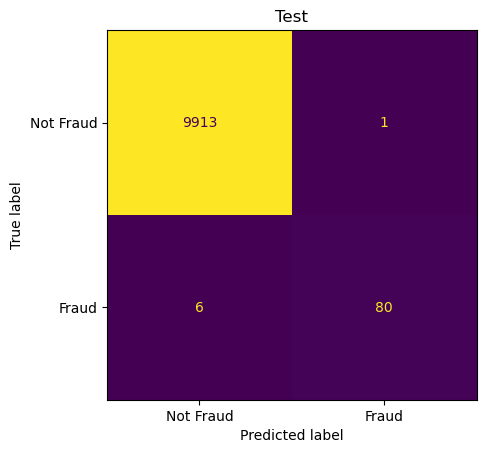

In [83]:
ConfusionMatrixDisplay.from_estimator(grid_rf_cs, X_test, y_test, cmap='viridis', display_labels=['Not Fraud', 'Fraud'], colorbar=False)
plt.title('Test')

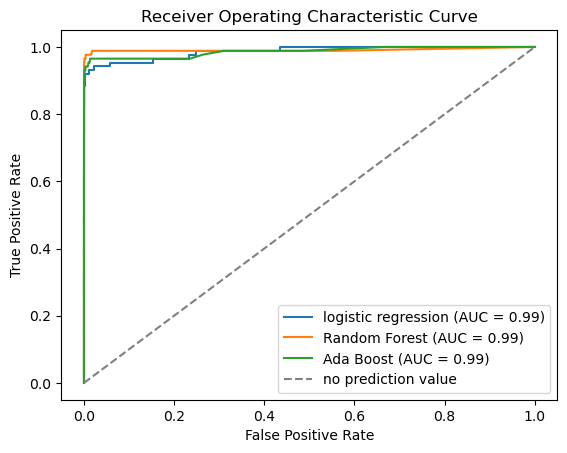

In [70]:
# Create an ax object
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(grid_lr, X_test, y_test, 
                               ax=ax, name='logistic regression')
RocCurveDisplay.from_estimator(grid_rf_cs, X_test, y_test, 
                               ax=ax, name='Random Forest')
RocCurveDisplay.from_estimator(abc_gs, X_test, y_test, 
                               ax=ax, name='Ada Boost')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Necessary to label the baseline
plt.legend();

Our confusion matrix of our final model and ROC curve plots are highlighted above. The ROC curve can be misleading because we know accuracy is not a particular useful metric for fraud detection with highly imbalanced classes. Nonetheless, it still helps us visualize the best algorithm at seperating the majority(not fraud) and minority class(fraud) which is the algorithm with the most area under the curve. The confusion matrix highlights how of our 86 total fraud observations our best model misses six of them. Nearly 100% of time we correctly classify the majority class. While, the Ada Boost algorithm is slighlty better at predicting fraud, the Random forest algorithm virtually never missclassifies the majority class. We must also consider the impact to customers when their credit cards are frozen for legitime transcation which causes inconviences to exhisting customers. 

### Summary and Recommendations

In this project, we leveraged a simulation to generate useful data to train and build a fraud detection model to protect consumers from credit card fraud. 
We analyzed the data and highlighted meaningful trends from the data that related to predicting fraudulent activity. We built several classification models to evaluate model performance and address the challenges of highly imbalanced classes. We engineered several features and transformed the data when applicable to aid in model performance. The final model was a Random Forest algorithm which was nearly 99% accurate, and our model did not detect only 1% of all instances of fraud. We recommend implementing our algorithm to reduce future fraud and protect consumers. 